In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib.patches as mpatches
import numpy as np
import sqlite3
from typing import List, Tuple, Dict
import warnings
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

Connect to the dataset

In [2]:
db = sqlite3.connect("aosp_acs.db", check_same_thread=False)

Queries

In [3]:
def cursor_to_dataframe(cursor):
    with warnings.catch_warnings():
        # TODO: pandas 2.1.0 has a FutureWarning for concatenating DataFrames with Null entries
        warnings.filterwarnings("ignore", category=FutureWarning)
        columns = [desc[0] for desc in (cursor.description)]
        df_records = pd.DataFrame(columns=columns)
        for row in cursor:
            df_temp = pd.DataFrame([row], columns=columns)
            if df_temp.empty:
                continue
            df_records = pd.concat([df_records, df_temp])
    return df_records.infer_objects().reset_index(drop=True)

In [4]:
def acs_in_a_project(project_name) -> pd.DataFrame:
    cursor = db.execute("SELECT count(id) as ac_count,path,ac,loc FROM ac_reports WHERE path IN (SELECT path FROM files WHERE files.project_name = ?) GROUP BY path,ac",(project_name,))
    return cursor_to_dataframe(cursor)

def acs_files(project_name) -> pd.DataFrame:
    sql = f"""
    SELECT files.path, coalesce(ac_count, 0) AS count_acs, loc, project_name
    FROM files
    LEFT JOIN
    (SELECT ac_reports.path AS ac_reports_path, count(id) AS ac_count
    FROM ac_reports
    WHERE project_name = '{project_name}'
    GROUP BY ac_reports.path)
    ON files.path = ac_reports_path
    WHERE files.project_name = '{project_name}'
    ORDER BY count_acs DESC;
    """
    cursor = db.execute(sql)
    return cursor_to_dataframe(cursor)

def ck_in_a_project(project_name) -> pd.DataFrame:
    cursor = db.execute("SELECT * from classes WHERE file_path IN (SELECT path FROM files WHERE files.project_name = ?)", (project_name,))
    df = cursor_to_dataframe(cursor)
    NUMERIC_FIELDS = ['cbo', 'cboModified', 'fanin',
       'fanout', 'wmc', 'dit', 'noc', 'rfc', 'lcom', 'lcom_normalized', 'tcc',
       'lcc', 'totalMethodsQty', 'staticMethodsQty', 'publicMethodsQty',
       'privateMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty',
       'visibleMethodsQty', 'abstractMethodsQty', 'finalMethodsQty',
       'synchronizedMethodsQty', 'totalFieldsQty', 'staticFieldsQty',
       'publicFieldsQty', 'privateFieldsQty', 'protectedFieldsQty',
       'defaultFieldsQty', 'finalFieldsQty', 'synchronizedFieldsQty', 'nosi',
       'loc', 'returnQty', 'loopQty', 'comparisonsQty', 'tryCatchQty',
       'parenthesizedExpsQty', 'stringLiteralsQty', 'numbersQty',
       'assignmentsQty', 'mathOperationsQty', 'variablesQty',
       'maxNestedBlocksQty', 'anonymousClassesQty', 'innerClassesQty',
       'lambdasQty', 'uniqueWordsQty', 'modifiers', 'logStatementsQty']
    for field in NUMERIC_FIELDS:
        df[field] = df[field].astype(float)
    return df

def ck_in_file(file_name: str):
    cursor = db.execute("SELECT * from classes WHERE file_path = ?", (file_name,))
    df = cursor_to_dataframe(cursor)
    return df


"""Prevalence report of AC in a project"""
def report_types_of_acs(project_name):
    sql = f"SELECT ac, count(id) as qty FROM ac_reports WHERE project_name LIKE '{project_name}' GROUP BY ac ORDER BY qty DESC"
    cursor = db.execute(sql)
    return cursor_to_dataframe(cursor)

def files_in_a_project(project_name) -> pd.DataFrame:
    cursor = db.execute("SELECT * FROM files WHERE project_name = ?", (project_name,))
    return cursor_to_dataframe(cursor)

def loc_of_file(file_name) -> int:
    cursor = db.execute("SELECT loc FROM files WHERE path = ?", (file_name,))
    return int(next(cursor)[0])

def report_loc_of_project(project_name) -> int:
    cursor = db.execute("SELECT sum(loc) FROM files WHERE project_name = ?", (project_name,))
    return int(next(cursor)[0])

def number_of_acs_in_files(project_name) -> dict:
    sql = f"""
    SELECT files.path, coalesce(ac_count, 0) AS count_acs
    FROM files
    LEFT JOIN
    (SELECT ac_reports.path AS ac_reports_path, count(id) AS ac_count
    FROM ac_reports
    WHERE project_name = '{project_name}'
    GROUP BY ac_reports.path)
    ON files.path = ac_reports_path
    WHERE files.project_name = '{project_name}'
    ORDER BY count_acs DESC;
    """
    cursor = db.execute(sql)
    return {k: v for k,v in cursor}

def report_files_with_acs(project_name) -> pd.Series:
    sql = f"SELECT DISTINCT path FROM ac_reports WHERE project_name = '{project_name}'"
    cursor = db.execute(sql)
    return pd.Series([tup[0] for tup in cursor])

def report_files_without_acs(project_name) -> pd.Series:
    sql = f"SELECT path FROM files WHERE project_name = '{project_name}'"
    cursor = db.execute(sql)
    all_files = [tup[0] for tup in cursor]
    files_with_ac = report_files_with_acs(project_name)
    return pd.Series([file for file in all_files if file not in files_with_ac])

def report_projects_with_atoms() -> pd.Series:
    sql = "SELECT project_name from ac_reports GROUP BY project_name"
    cursor = db.execute(sql)
    all_projs_with_acs = [tup[0] for tup in cursor]
    return pd.Series(all_projs_with_acs)

In [5]:
def identity(x):
    return x

In [5]:
cursor = db.execute("SELECT path, count(ac) as ac_count FROM ac_reports WHERE ac = ? GROUP BY path ORDER BY ac_count DESC", ("Type Conversion",))
next(cursor)

('/AOSP/external/conscrypt/repackaged/common/src/test/java/com/android/org/conscrypt/java/security/SignatureTest.java',
 3685)

In [6]:
report_projects_with_atoms()

0                                art
1                  bootable/recovery
2                         build/make
3                                cts
4                             dalvik
                   ...              
326            tools/platform-compat
327                   tools/security
328     tools/test/graphicsbenchmark
329    tools/tradefederation/contrib
330       tools/tradefederation/core
Length: 331, dtype: object

Get the list of core apps

In [6]:
cursor = db.execute("SELECT * FROM files;")
ALL_PROJECTS = set()
for path,loc, project_name in cursor:
    ALL_PROJECTS.add(project_name)

In [7]:
cursor = db.execute("SELECT ac FROM ac_reports;")
ALL_ACS = set()
for ac, in cursor:
    ALL_ACS.add(ac)

In [8]:
ALL_ACS

{'Arithmetic as Logic',
 'Change of Literal Encoding',
 'Conditional Operator',
 'Infix Operator Precedence',
 'Logic as Control Flow',
 'Omitted Curly Braces',
 'Post Increment Decrement',
 'Pre Increment Decrement',
 'Repurposed Variables',
 'Type Conversion'}

In [54]:
cursor = db.execute("SELECT * FROM files;")
apps_set = set()
for path,loc, project_name in cursor:
    apps_set.add(project_name)

In [12]:
def get_app_data(project_name: str) -> tuple[str, dict]:
    return (project_name, {
        "ck": ck_in_a_project(project_name),
        "acs": acs_in_a_project(project_name),
        "files": files_in_a_project(project_name)
    })
apps_data :Dict[str, Dict[str, pd.DataFrame]] = {}
with ThreadPoolExecutor(max_workers=5) as executor:
    jobs = [executor.submit(get_app_data, project) for project in apps_set]
    for job in as_completed(jobs):
        proj, result = job.result()
        apps_data[proj] = result
# for project in apps_set:
#     apps_data[project] = {
#         "ck": ck_in_a_project(project),
#         "acs": acs_in_a_project(project),
#         "files": files_in_a_project(project)
#     }

print("Projects processed: ", len(apps_data.keys()))

Projects processed:  370


AVG, median, percentiles...

In [13]:
def process_ck(df: pd.DataFrame) -> pd.DataFrame:
    pd_recast_numeric = pd.DataFrame()
    output = pd.DataFrame()
    for col in df.columns:
        try:
            if col in ["id", "file_path"]:
                raise ValueError
            pd_recast_numeric[col] = pd.to_numeric(df[col])
            # output[f"{col}__mean"] = pd_recast_numeric[col].mean(skipna=True)
            # output[f"{col}__median"] = pd_recast_numeric[col].median(skipna=True)
            # output[f"{col}__90_perc"] = pd_recast_numeric[col].quantile(.90 )
        except ValueError:
            continue
        except Exception as e:
            print("Exception: ", e)
            print(f"Skipping column {col} of type {pd_recast_numeric[col].dtype}")
    return pd_recast_numeric.describe()

In [14]:
apps_data[project_name]["acs"].loc[apps_data[project_name]["acs"]["ac"] == "Logic as Control Flow"]["ac_count"].sum()

np.int64(1199)

In [15]:
%%script echo skipping
def countacs(project_name: str) -> pd.DataFrame:
    loc_sum = apps_data[project_name]["files"]["loc"].sum()
    ac_count = apps_data[project_name]["acs"]["ac_count"].sum()
    loc_by_acs = loc_sum/ac_count if ac_count > 0 else -1
    return pd.DataFrame([(loc_sum, ac_count, loc_by_acs)], columns=["loc_sum", "ac_count", "loc_by_acs"])



df_apps_ac: pd.DataFrame = pd.DataFrame()
for idx, project_name in enumerate(apps_set):
    apps_ac_map = countacs(project_name)
    apps_ac_map = apps_ac_map.assign(project_name=[project_name])
    df_apps_ac = pd.concat([df_apps_ac, apps_ac_map])
df_apps_ac = df_apps_ac.reset_index(drop=True)

df_loc_by_acs = df_apps_ac.sort_values("loc_by_acs", ascending=True)

fig, ax = plt.subplots()


ax.bar(df_loc_by_acs["project_name"], df_loc_by_acs["loc_by_acs"], 0.9)
ax.figure.set_figwidth(12)
ax.figure.set_figheight(5)
ax.yaxis.set_label_text("Lines of code per AC")
ax.xaxis.set_label_text("Project Name")

plt.xticks(rotation=90)
plt.savefig("fig.png")


skipping


In [16]:
def plot_ac_report_bar(project_name):
    df_report = report_types_of_acs(project_name)
    df_report = df_report.assign(perc=(df_report["qty"] / df_report["qty"].sum()).astype(float).round(2))
    df_report = df_report.assign(label=df_report["ac"] + " " + df_report["perc"].astype(str))
    fig, ax = plt.subplots()
    ax.figure.set_figwidth(12)
    ax.figure.set_figheight(5)
    wedges, _ = ax.pie(df_report["perc"], wedgeprops=dict(width=0.5), startangle=0)

    # https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        Epsilon = .00001
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        if ang == 180:
            ang = 179
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(df_report["label"][i], xy=(x + Epsilon, y + Epsilon), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
    ax.set_title(f"Prevalence of {project_name}")
    plt.savefig(f"imgs/prevalence_{project_name.replace('/', '_')}.png")
    plt.close()



In [17]:
%%script echo skipping
for project_name in apps_set:
    try:
        plot_ac_report_bar(project_name)
    except:
        print(f"Failed to render graph for {project_name}")

skipping


In [18]:
def correlation_with_loc(project_name):
    corr_test = acs_in_a_project(project_name).groupby("path").agg({"ac_count": "sum", "loc": "max"}).reset_index()
    corr_test["ac_count"] = corr_test["ac_count"].astype(int)
    corr_test["loc"] = corr_test["loc"].astype(int)
    return corr_test.corr("pearson", numeric_only=True)["ac_count"]["loc"]

def export_ac_cout_loc(project_name:str):
    df = acs_in_a_project(project_name).groupby("path").agg({"ac_count": "sum", "loc": "max"}).reset_index()
    escaped_project_name = project_name.replace("/","_")
    df.to_csv(f"./corrs/{escaped_project_name}.csv")

In [19]:
for proj in apps_set:
    export_ac_cout_loc(proj)

In [20]:
corrs = [(projname, correlation_with_loc(projname)) for projname in apps_set]

## Filewise analysis

In [55]:
agg_methods = {'cbo': 'sum',
               'cboModified': 'sum',
               'fanin': 'sum',
               'fanout': 'sum',
               'wmc': 'sum',
               'dit': 'sum',
               'noc': 'sum',
               'rfc': 'sum',
               'lcom': 'sum',
               'lcom_normalized': 'mean',
               'tcc': 'mean',
               'lcc': 'mean',
               'totalMethodsQty': 'sum',
               'staticMethodsQty': 'sum',
               'publicMethodsQty': 'sum',
               'privateMethodsQty': 'sum',
               'protectedMethodsQty': 'sum',
               'defaultMethodsQty': 'sum',
               'visibleMethodsQty': 'sum',
               'abstractMethodsQty': 'sum',
               'finalMethodsQty': 'sum',
               'synchronizedMethodsQty': 'sum',
               'totalFieldsQty': 'sum',
               'staticFieldsQty': 'sum',
               'publicFieldsQty': 'sum',
               'privateFieldsQty': 'sum',
               'protectedFieldsQty': 'sum',
               'defaultFieldsQty': 'sum',
               'finalFieldsQty': 'sum',
               'synchronizedFieldsQty': 'sum',
               'nosi': 'sum',
               'loc': 'sum', # does not matter, will be replaced
               'returnQty': 'sum',
               'loopQty': 'sum',
               'comparisonsQty': 'sum',
               'tryCatchQty': 'sum',
               'parenthesizedExpsQty': 'sum',
               'stringLiteralsQty': 'sum',
               'numbersQty': 'sum',
               'assignmentsQty': 'sum',
               'mathOperationsQty': 'sum',
               'variablesQty': 'sum',
               'maxNestedBlocksQty': 'sum',
               'anonymousClassesQty': 'sum',
               'innerClassesQty': 'sum',
               'lambdasQty': 'sum',
               'uniqueWordsQty': 'sum',
               'modifiers': 'sum',
               'logStatementsQty': 'sum'}

In [22]:
pd.Series(agg_methods).to_csv("agg_methods.csv")

In [58]:
def ac_ck_pipeline(project_name: str):
    df_ck = ck_in_a_project(project_name)
    
    df_ck = df_ck.groupby("file_path").agg(agg_methods, numeric_only=True).reset_index()
    df_ck["file_path"] = df_ck["file_path"].astype("str")
    df_ck["path"] = df_ck["file_path"]
    df_files = files_in_a_project(project_name)[["path", "loc"]]
    df_files["path"] = df_files["path"].astype(str)
    df_ck.drop(columns=["loc"], inplace=True) # drop loc, use from files instead.

    pd_merged = pd.merge(df_files, df_ck, how="left", on="path")
    df_ac = acs_in_a_project(project_name)[["path", "ac_count"]].groupby("path").agg({"ac_count": "sum"}).reset_index()

    pd_merged = pd.merge(pd_merged, df_ac, how="left", on="path")
    pd_merged.infer_objects(copy=False)
    pd_merged["ac_count"] = pd_merged["ac_count"].astype(float).fillna(0).astype(int)
    pd_merged["loc"] = pd_merged["loc"].astype(int)
    pd_merged["atom_rate"] = pd_merged["ac_count"] / pd_merged["loc"]
    pd_merged.drop(columns=["file_path"], inplace=True)
    return pd_merged


In [ ]:
def get_correlations(projects: List[str]):
    _df_correlations = pd.DataFrame()
    records = []
    for i, project_name in enumerate(projects):
        record = ac_ck_pipeline(project_name)
        # record["files_with_ac"] = pd_merged.query("ac_count > 0")["file_path"].size
        # record["diffusion_file"] = pd_merged["file_path"].size / pd_merged.query("ac_count > 0")["file_path"]
        record = record.corr(method="pearson", numeric_only=True)["ac_count"]
        record["project_name"] = project_name
        records.append(record)
    _df_correlations = pd.DataFrame.from_records(records)
    return _df_correlations

def get_correlations_raw(projects: List[str]):
    _df_correlations = pd.DataFrame()
    records = pd.DataFrame()
    for i, project_name in enumerate(projects):
        record = ac_ck_pipeline(project_name)
        # record["files_with_ac"] = pd_merged.query("ac_count > 0")["file_path"].size
        # record["diffusion_file"] = pd_merged["file_path"].size / pd_merged.query("ac_count > 0")["file_path"]
        records = pd.concat([records,record])
    return records

df_correlations = get_correlations(ALL_PROJECTS)
df_file_correlations = get_correlations_raw(ALL_PROJECTS)

In [ ]:
df_ignore_null_metrics = df_file_correlations.dropna(subset=["wmc"])
df_ignore_null_metrics[df_ignore_null_metrics["ac_count"] > 0]["ac_count"].describe()

count    29077.000000
mean         8.167761
std         56.303559
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max       3695.000000
Name: ac_count, dtype: float64

In [55]:
df_correlations.plot(kind="box", figsize=(15,6), rot=90, title="Pearson Correlation with ac_count")

TypeError: no numeric data to plot

In [57]:
df_correlations

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,path,loc,cbo,cboModified,fanin,fanout,wmc,dit,noc,rfc,...,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty,ac_count,atom_rate
1,path,loc,cbo,cboModified,fanin,fanout,wmc,dit,noc,rfc,...,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty,ac_count,atom_rate
2,path,loc,cbo,cboModified,fanin,fanout,wmc,dit,noc,rfc,...,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty,ac_count,atom_rate
3,path,loc,cbo,cboModified,fanin,fanout,wmc,dit,noc,rfc,...,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty,ac_count,atom_rate
4,path,loc,cbo,cboModified,fanin,fanout,wmc,dit,noc,rfc,...,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty,ac_count,atom_rate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,path,loc,cbo,cboModified,fanin,fanout,wmc,dit,noc,rfc,...,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty,ac_count,atom_rate
366,path,loc,cbo,cboModified,fanin,fanout,wmc,dit,noc,rfc,...,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty,ac_count,atom_rate
367,path,loc,cbo,cboModified,fanin,fanout,wmc,dit,noc,rfc,...,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty,ac_count,atom_rate
368,path,loc,cbo,cboModified,fanin,fanout,wmc,dit,noc,rfc,...,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty,ac_count,atom_rate


In [26]:
%%script echo skipping
df_correlations_atom_rate = pd.DataFrame()
records = []
for i, project_name in enumerate(apps_set):
    record = ac_ck_pipeline(project_name)
    # record["files_with_ac"] = pd_merged.query("ac_count > 0")["file_path"].size
    # record["diffusion_file"] = pd_merged["file_path"].size / pd_merged.query("ac_count > 0")["file_path"]
    record = record.corr(method="pearson", numeric_only=True)["atom_rate"]
    record["project_name"] = project_name
    records.append(record)
df_correlations_atom_rate = pd.DataFrame.from_records(records)

df_correlations_atom_rate.plot(kind="box", figsize=(15,6), rot=90, title="Pearson Correlation with atom_rate")

skipping


In [27]:
# df_correlations.to_csv("corr_per_project_mean.csv", index=False)

In [28]:
records = []
for app in apps_set:
    df_files = files_in_a_project(app)
    df_ac = acs_in_a_project(app)
    serie_files_with_ac = report_files_with_acs(app)
    records.append({
        "project_name": app,
        "file_qty": df_files.size,
        "loc_sum": df_files["loc"].sum(),
        "files_with_ac_perc": serie_files_with_ac.size / df_files.size
    })
df_metrics = pd.DataFrame.from_records(records)
df_metrics

,project_name,file_qty,loc_sum,files_with_ac_perc
0,packages/services/Iwlan,102,18856,0.137255
1,test/vts,51,2389,0.176471
2,external/turbine,633,48408,0.129542
3,packages/apps/Gallery,144,12571,0.159722
4,packages/apps/OnDeviceAppPrediction,3,268,0.333333
...,...,...,...,...
365,packages/apps/SystemUIGo,18,596,0.000000
366,external/flatbuffers,324,12882,0.114198
367,external/jsr330,69,2029,0.000000
368,external/ksoap2,114,6660,0.140351


## Projects without ACs

In [29]:
projects_with_atoms = report_projects_with_atoms().to_list()
print ("Projects without atoms of confusion: ",len([p for p in ALL_PROJECTS if p not in projects_with_atoms]))

Projects without atoms of confusion:  39


## Projectwise analysis

In [56]:
def ac_ck_pipeline_projectwise(project_name: str):
    agg_methods_copy = agg_methods.copy()
    df_merged = ac_ck_pipeline(project_name)
    df_merged.drop(columns=["path"], inplace=True)
    # Aggregation dict
    agg_methods_copy["loc"] = "sum" # sum aggregation for LoC
    agg_methods_copy["ac_count"] = "sum" # sum aggregation for ac count
    df_merged = df_merged.agg(agg_methods_copy, numeric_only=True)
    df_merged["project_name"] = project_name

    # put project_name first
    columns = list(df_merged.index)
    columns.insert(0, columns.pop())
    df_merged = df_merged[columns]
    return df_merged

In [59]:
records: List[pd.Series] = []
for project_name in apps_set:
    record = ac_ck_pipeline_projectwise(project_name)
    nfa = report_files_with_acs(project_name).size
    nft = files_in_a_project(project_name).size
    record["acdif"] = nfa/nft
    record["acden"] = record["ac_count"] / nft
    record["ac_per_kloc"] = (record["ac_count"] / record["loc"]) * 1000
    records.append(record)
df_project_wise_analysis = pd.concat(records, axis=1).T
df_project_wise_analysis = df_project_wise_analysis.infer_objects()
for col in df_project_wise_analysis.columns:
    if col != "project_name":
        df_project_wise_analysis[col] = df_project_wise_analysis[col].astype(float)


In [67]:
df_project_wise_analysis.sort_values(by="ac_per_kloc", ascending=False)[["project_name", "loc", "ac_per_kloc", "ac_count"]].head(10).to_latex("ac_per_kloc.txt", index=False)

In [32]:
scaler = RobustScaler()
df_project_wise_analysis_scaled =df_project_wise_analysis
df_project_wise_analysis_scaled = df_project_wise_analysis_scaled.drop(columns=["project_name"])
df_project_wise_analysis_scaled.columns = [c for c in df_project_wise_analysis.columns if c != "project_name"]
df_project_wise_analysis_scaled.index = df_project_wise_analysis["project_name"].values
df_project_wise_analysis_scaled = pd.DataFrame(scaler.fit_transform(df_project_wise_analysis_scaled), index=df_project_wise_analysis_scaled.index, columns=df_project_wise_analysis_scaled.columns)
df_project_wise_corr = df_project_wise_analysis_scaled.corr(method="pearson", numeric_only=True)


In [33]:
df_project_wise_corr["ac_count"].sort_values(ascending=False)

ac_count                  1.000000
loc                       0.944140
numbersQty                0.573948
mathOperationsQty         0.553572
loopQty                   0.550816
assignmentsQty            0.550053
returnQty                 0.545347
nosi                      0.544475
wmc                       0.537509
maxNestedBlocksQty        0.536657
staticMethodsQty          0.535798
comparisonsQty            0.533313
privateMethodsQty         0.523587
uniqueWordsQty            0.521996
stringLiteralsQty         0.517251
tryCatchQty               0.512118
finalFieldsQty            0.504367
rfc                       0.502347
defaultFieldsQty          0.495494
parenthesizedExpsQty      0.490965
variablesQty              0.490033
cboModified               0.488812
fanin                     0.485616
totalMethodsQty           0.485308
privateFieldsQty          0.484852
dit                       0.482909
fanout                    0.480524
cbo                       0.479882
visibleMethodsQty   

In [34]:
df_project_wise_analysis.to_csv("df_project_wise_analysis.csv", index=False)

## Atom breakdown per project

In [35]:
atom_breakdown: List[Dict[str, pd.DataFrame]] = []
for project_name in ALL_PROJECTS:
    atom_breakdown.append({"project_name": project_name, "breakdown": report_types_of_acs(project_name)})

In [36]:
def convert_name(string:str):
    return string.replace("/", "_")

for entry in atom_breakdown:
    entry["breakdown"].to_csv(f"ac_breakdown/ac_breakdown_{convert_name(entry['project_name'])}.csv", index=False)

In [37]:
df_ac_prevalence = pd.Series([0] * len(ALL_ACS),index=ALL_ACS)
for entry in atom_breakdown:
    atoms_in_breakdown = entry["breakdown"]['ac'].to_list()
    for atom in ALL_ACS:
        df_ac_prevalence[atom] = df_ac_prevalence[atom] + (1 if atom in atoms_in_breakdown else 0)
df_ac_prevalence = df_ac_prevalence.apply(lambda x: x / len(ALL_PROJECTS) * 100)


In [38]:
df_ac_prevalence.to_csv("Prevalencia total.csv")

In [39]:
for initial in set(p.split("/")[0] for p in ALL_PROJECTS if "/" in p):
    print(initial)

packages
hardware
tools
system
bootable
device
prebuilts
external
frameworks
developers
test
build


In [40]:
def generate_breakdown_chart(filter_str: str, save=""):
    filtered_projects = ALL_PROJECTS
    if filter_str:
        filtered_projects = [p for p in filter(lambda x: filter_str in x, ALL_PROJECTS)]

    display_title = filter_str if filter_str else "AOSP"

    _df_ac_prevalence = pd.Series([0] * len(ALL_ACS),index=ALL_ACS)
    if len(filtered_projects) == 0:
        raise Exception(f"No project matches the filter string \"{filter_str}\"")
    projs_with_ac = 0
    for _project_name in filtered_projects:
        _atoms_in_breakdown = report_types_of_acs(_project_name)['ac'].to_list()
        if _atoms_in_breakdown:
            projs_with_ac += 1
        for atom in ALL_ACS:
            _df_ac_prevalence[atom] = _df_ac_prevalence[atom] + (1 if atom in _atoms_in_breakdown else 0)
    _df_atom_counts_per_project = _df_ac_prevalence.copy()
    _df_ac_prevalence = _df_ac_prevalence.apply(lambda x: x / projs_with_ac * 100)
    ax = _df_ac_prevalence.sort_values().plot(kind="barh",figsize=(12,8), title=f"Prevalence across \"{display_title}\"")
    ax.bar_label(ax.containers[0], fmt="%.2f")
    plt.xticks = [i for i in range(0, 100, 10)]
    plt.tight_layout()
    if save:
        plt.savefig(f"{save}.png", dpi=300)
        _df_ac_prevalence.to_csv(f"{save}.csv")
        _df_atom_counts_per_project.sort_values().to_csv(f"{save}_qty.csv")
    plt.close()


In [41]:
def generate_frequency_reports(filter_str: str = None, save=""):
    filtered_projects = ALL_PROJECTS
    if filter_str:
        filtered_projects = [p for p in filter(lambda x: filter_str in x, ALL_PROJECTS)]

    _df_ac_frequency = pd.DataFrame([[0] * len(ALL_ACS)],columns=list(ALL_ACS))
    if len(filtered_projects) == 0:
        raise Exception(f"No project matches the filter string \"{filter_str}\"")
    for _project_name in filtered_projects:
        report = report_types_of_acs(_project_name)
        cols = report["ac"].to_list()
        qtds = report["qty"].to_list()
        report = pd.DataFrame([qtds], columns=cols)
        _df_ac_frequency = _df_ac_frequency.add(report, fill_value=0)
    if save:
        _df_ac_frequency.to_csv(f"{save}.csv", index=False)
    return _df_ac_frequency

In [42]:
def generate_distribution(filter_str: str = None):
    filtered_projects = ALL_PROJECTS
    if filter_str:
        filtered_projects = [p for p in filter(lambda x: filter_str in x, ALL_PROJECTS)]
    categories = set(p.split("/")[0] for p in ALL_PROJECTS)
    records = []
    for _project_name in filtered_projects:
        with_acs = report_files_with_acs(_project_name)
        without_acs = report_files_without_acs(_project_name)
        records.append({
            "project_name": _project_name,
            "files_with_acs": with_acs.size,
            "files_without_acs": without_acs.size
        })
    _df = pd.DataFrame.from_records(records)
    grouped = []
    for c in categories:
        filtered_by_category = _df.query("project_name.str.startswith(@c)", engine="python")
        _agg = filtered_by_category.sum(numeric_only=True)
        grouped.append(
            {
                "project_name": c,
                "files_with_acs": _agg["files_with_acs"],
                "files_without_acs": _agg["files_without_acs"]
            }
        )
    return pd.DataFrame.from_records(grouped)

In [43]:
pd_all_distribution = generate_distribution()

In [44]:
pd_all_distribution.to_csv("All distribution.csv", index=None)

In [45]:
for initial in set(p.split("/")[0] for p in ALL_PROJECTS if "/" in p):
    try:
        generate_breakdown_chart(initial, save=f"breakdown_charts/{initial}.png")
    except Exception as ex:
        print(ex)

RQ1- Como se dá a distribuição dos ACs no ecosistema? ( frequência e prevalência geral de todos os 370 repos)

In [46]:
generate_breakdown_chart(None, save="results/rq1")

In [47]:
tst = generate_frequency_reports(save="results/rq1_frequency")

In [48]:
tst.to_csv("Frequency Reports.csv", index=None)

KeyboardInterrupt: 

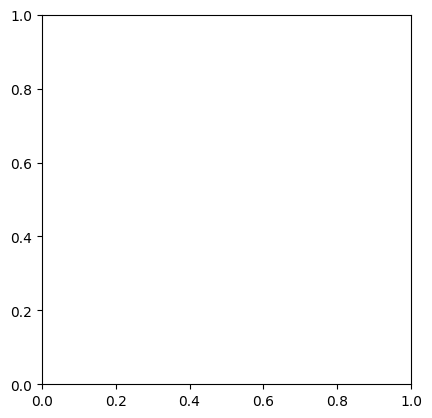

In [49]:
plt.pie(tst.iloc[0].values, labels=tst.columns)

In [ ]:
tst.apply(lambda x: x * 100/ tst.sum(axis=1))

,Arithmetic as Logic,Change of Literal Encoding,Conditional Operator,Infix Operator Precedence,Logic as Control Flow,Omitted Curly Braces,Post Increment Decrement,Pre Increment Decrement,Repurposed Variables,Type Conversion
0,0.021086,1.287184,22.171832,10.210986,33.797131,0.013752,4.434855,1.24715,0.051646,26.764377


RQ2- Em que medida a “distribuição” destes ACs através dos módulos?


RQ3- Qual a correlação entre as métricas de qualidade de software e os átomos de confusão no ecosistema? (no geral)


RQ4 - Qual a correlação entre frameworks/base/core e packages/apps

## Heatmap


In [9]:
def acronym_ac(ac_name: str) -> str:
    ac_map = {
        "Change of Literal Encoding":"CoLE",
        "Conditional Operator":"CO",
        "Infix Operator Precedence":"IOP",
        "Logic as Control Flow":"LaCF",
        "Post Increment Decrement":"Post-Inc/Dec",
        "Pre Increment Decrement":"Pre-Inc/Dec",
        "Type Conversion":"TC",
        "Omitted Curly Braces":"OCB",
        "Repurposed Variables": "RV",
        "Arithmetic as Logic" : "AaL"
    }
    return f"{ac_map.get(ac_name, ac_name)}"

def pivot_results(df: pd.DataFrame) ->pd.Series:
    df_pivoted = pd.pivot_table(df, columns="ac", values="qty")
    # df_pivoted["counts"] = df_pivoted.infer_objects(copy=False).fillna(0).to_numpy().sum()
    filter_list = ["ac", "project_name"]
    # df_pivoted = df_pivoted.apply(lambda x: x / df_pivoted["counts"] if df_pivoted["counts"] != 0 else 0)
    df_pivoted.columns = [acronym_ac(x) for x in df_pivoted.columns if x not in filter_list]
    # df_pivoted["project_name"] = project_name
    return df_pivoted.loc["qty"]


In [103]:

"""Aggregates a heatmap plot by domain, e.g. packages, frameworks, external...
"""
def aggregate_heatmap_by_domain(df: pd.DataFrame, normalize=False, attenuate: int=0, use_loc=False) -> pd.DataFrame:
    
    domains = set([i.split("/")[0] for i in df.index])
    df_heatmap_aggregated = pd.DataFrame()
    for domain in domains:
        temp = df.loc[df.index.str.startswith(domain)]
        temp = temp.agg("sum")
        temp = pd.DataFrame(temp.to_dict(), index=[domain])
        df_heatmap_aggregated = pd.concat([df_heatmap_aggregated, temp])
    return df_heatmap_aggregated

def make_heatmap_dfs():
    heatmap = pd.DataFrame()
    for project_name in ALL_PROJECTS:
        asd = pivot_results(report_types_of_acs(project_name))
        asd = pd.DataFrame(asd.to_dict(), index=[project_name])
        asd["loc"] = report_loc_of_project(project_name)
        heatmap = pd.concat([heatmap, asd])
    heatmap = heatmap.fillna(0)
    # heatmap_normalized = heatmap.div(heatmap.sum(axis=1), axis=0)
    heatmap_normalized = heatmap.div(heatmap["loc"], axis=0).mul(1000, axis=0)
    heatmap_normalized = heatmap_normalized.fillna(0)
    heatmap_loc = heatmap
    heatmap = heatmap.drop(columns=["loc"])
    heatmap_loc["ac_count"] = heatmap.sum(axis=1, numeric_only=True)
    heatmap_normalized = heatmap_normalized.drop(columns=["loc"])
    return heatmap, heatmap_loc
heatmap, heatmap_loc = make_heatmap_dfs()

def make_heatmap_normalized():
    heatmap = pd.DataFrame()
    for project_name in ALL_PROJECTS:
        asd = pivot_results(report_types_of_acs(project_name))
        asd = pd.DataFrame(asd.to_dict(), index=[project_name])
        asd["loc"] = report_loc_of_project(project_name)
        heatmap = pd.concat([heatmap, asd])
    heatmap = heatmap.fillna(0)
    heatmap = aggregate_heatmap_by_domain(heatmap)
    heatmap_normalized = heatmap.div(heatmap["loc"], axis=0).mul(1000, axis=0)
    heatmap_normalized = heatmap_normalized.fillna(0)
    return heatmap_normalized
heatmap_normalized = make_heatmap_normalized()

In [81]:
heatmap_loc.sort_values(by="ac_count", ascending=False)

,CO,IOP,LaCF,Pre-Inc/Dec,TC,loc,Post-Inc/Dec,CoLE,AaL,RV,OCB,ac_count
frameworks/base,16744.0,5693.0,26914.0,251.0,5814.0,6024034,1229.0,732.0,8.0,2.0,0.0,57387.0
cts,5676.0,8733.0,6184.0,149.0,11568.0,2618448,464.0,122.0,5.0,1.0,0.0,32902.0
external/icu,3449.0,1333.0,8162.0,671.0,5829.0,1084281,2376.0,421.0,10.0,11.0,9.0,22271.0
libcore,4069.0,1105.0,5359.0,558.0,9564.0,2020642,1125.0,234.0,7.0,85.0,10.0,22116.0
external/conscrypt,316.0,43.0,799.0,4.0,17829.0,174220,61.0,4.0,0.0,0.0,0.0,19056.0
...,...,...,...,...,...,...,...,...,...,...,...,...
prebuilts/module_sdk/conscrypt,0.0,0.0,0.0,0.0,0.0,1283,0.0,0.0,0.0,0.0,0.0,0.0
build/bazel,0.0,0.0,0.0,0.0,0.0,145,0.0,0.0,0.0,0.0,0.0,0.0
external/icing,0.0,0.0,0.0,0.0,0.0,2276,0.0,0.0,0.0,0.0,0.0,0.0
external/nist-pkits,0.0,0.0,0.0,0.0,0.0,3103,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
heatmap_normalized.sort_values(by="LaCF", ascending=False)

,CO,IOP,LaCF,Pre-Inc/Dec,TC,Post-Inc/Dec,CoLE,AaL,RV,OCB
prebuilts/misc,0.000000,0.000000,20.979021,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
packages/apps/CarrierConfig,7.884363,0.000000,14.454665,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
external/s2-geometry-library-java,6.520064,5.038231,13.395768,0.237093,1.007646,0.592733,1.659653,0.0,0.0,0.0
external/xmp_toolkit,1.749831,0.451569,12.587492,0.056446,0.790246,1.185369,0.000000,0.0,0.0,0.0
packages/apps/CertInstaller,2.035623,0.000000,12.213740,0.000000,2.544529,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
packages/apps/Provision,2.386635,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
system/linkerconfig,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
packages/apps/Car/LinkViewer,18.018018,9.009009,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
external/nist-pkits,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [94]:
plt.figure(figsize=(120, 90))
sns.heatmap(heatmap_normalized.sort_index().T, square=True,)

<Axes: >

In [ ]:
from matplotlib.colors import LogNorm, Normalize


def filter_heatmap_by_query(df: pd.DataFrame, query: str) -> pd.DataFrame:
    if not query and not isinstance(query, str):
        raise ValueError("Please add a valid query.")
    return df.loc[df.index.str.startswith(query)]

def print_heatmap(df: pd.DataFrame, title="Heatmap", annot=False):
    plt.figure(figsize=(30, 9))
    plt.rcParams.update({"axes.titlesize": 12})
    cmap = [i for i in zip(np.linspace(255, 127, 50), np.linspace(255, 0, 50), np.linspace(255, 255, 50))]
    ax = sns.heatmap(df.sort_index().T, cmap="Purples",linewidths=.5, annot=annot, square=True, fmt=".4", annot_kws={"fontsize": "medium"}, norm=LogNorm())
    # ax.set_title(title, fontdict={"fontsize": "x-large", "fontweight": "bold"})
    ax.set_xticklabels(df.sort_index().index, fontsize='xx-large')
    ax.set_yticklabels(df.sort_index().columns, fontsize='xx-large')
    ax.set_xlabel("Repositories", fontsize="xx-large")
    ax.set_ylabel("Atoms of Confusion", fontsize="xx-large")
    plt.yticks(rotation=0)
    return ax

In [96]:
filter_heatmap_by_query(heatmap_loc, "external")["loc"].sum()

np.int64(10116182)

<Axes: xlabel='Repositories', ylabel='Atoms of Confusion'>

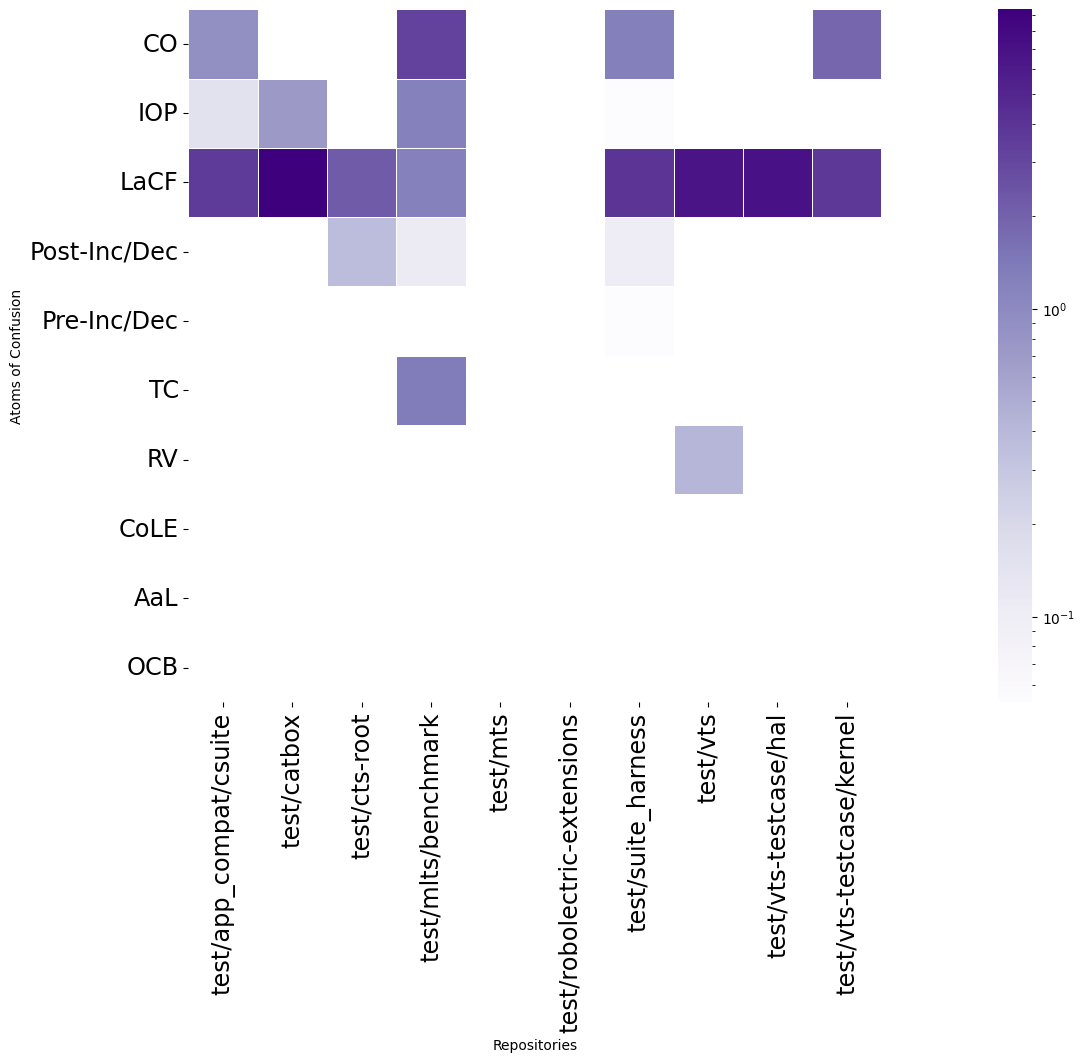

In [ ]:
print_heatmap(filter_heatmap_by_query(heatmap_normalized, "test"), annot=False)

In [ ]:
# print_heatmap(filter_heatmap_by_query(heatmap, "frameworks"), annot=False)

In [ ]:
# print_heatmap(filter_heatmap_by_query(heatmap, "packages"), title="Heatmap for \"packages\"", annot=False)

NameError: name 'heatmap' is not defined

In [93]:
heatmap_normalized

,CO,IOP,LaCF,Pre-Inc/Dec,TC,Post-Inc/Dec,CoLE,AaL,RV,OCB
packages/modules/RemoteKeyProvisioning,0.601581,0.257821,2.406325,0.085940,1.203163,0.000000,0.000000,0.000000,0.000000,0.0
external/connectedappssdk,0.792597,0.000000,1.545564,0.000000,0.039630,0.198149,0.000000,0.000000,0.000000,0.0
external/mp4parser,4.291436,4.863628,3.019900,0.190730,4.196071,0.826499,0.731134,0.000000,0.000000,0.0
frameworks/base,2.779533,0.945048,4.467770,0.041666,0.965134,0.204016,0.121513,0.001328,0.000332,0.0
packages/providers/DownloadProvider,2.437923,0.270880,6.501129,0.090293,0.361174,0.180587,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
system/linkerconfig,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
development,1.817829,1.407146,1.957907,0.054121,1.438982,0.264238,0.038203,0.000000,0.000000,0.0
external/tensorflow,1.721115,2.240696,1.298954,0.064948,2.305644,0.422160,0.032474,0.000000,0.000000,0.0
external/android-key-attestation,0.000000,0.000000,0.780640,0.000000,0.000000,0.000000,0.780640,0.000000,0.000000,0.0


<Axes: xlabel='Repositories', ylabel='Atoms of Confusion'>

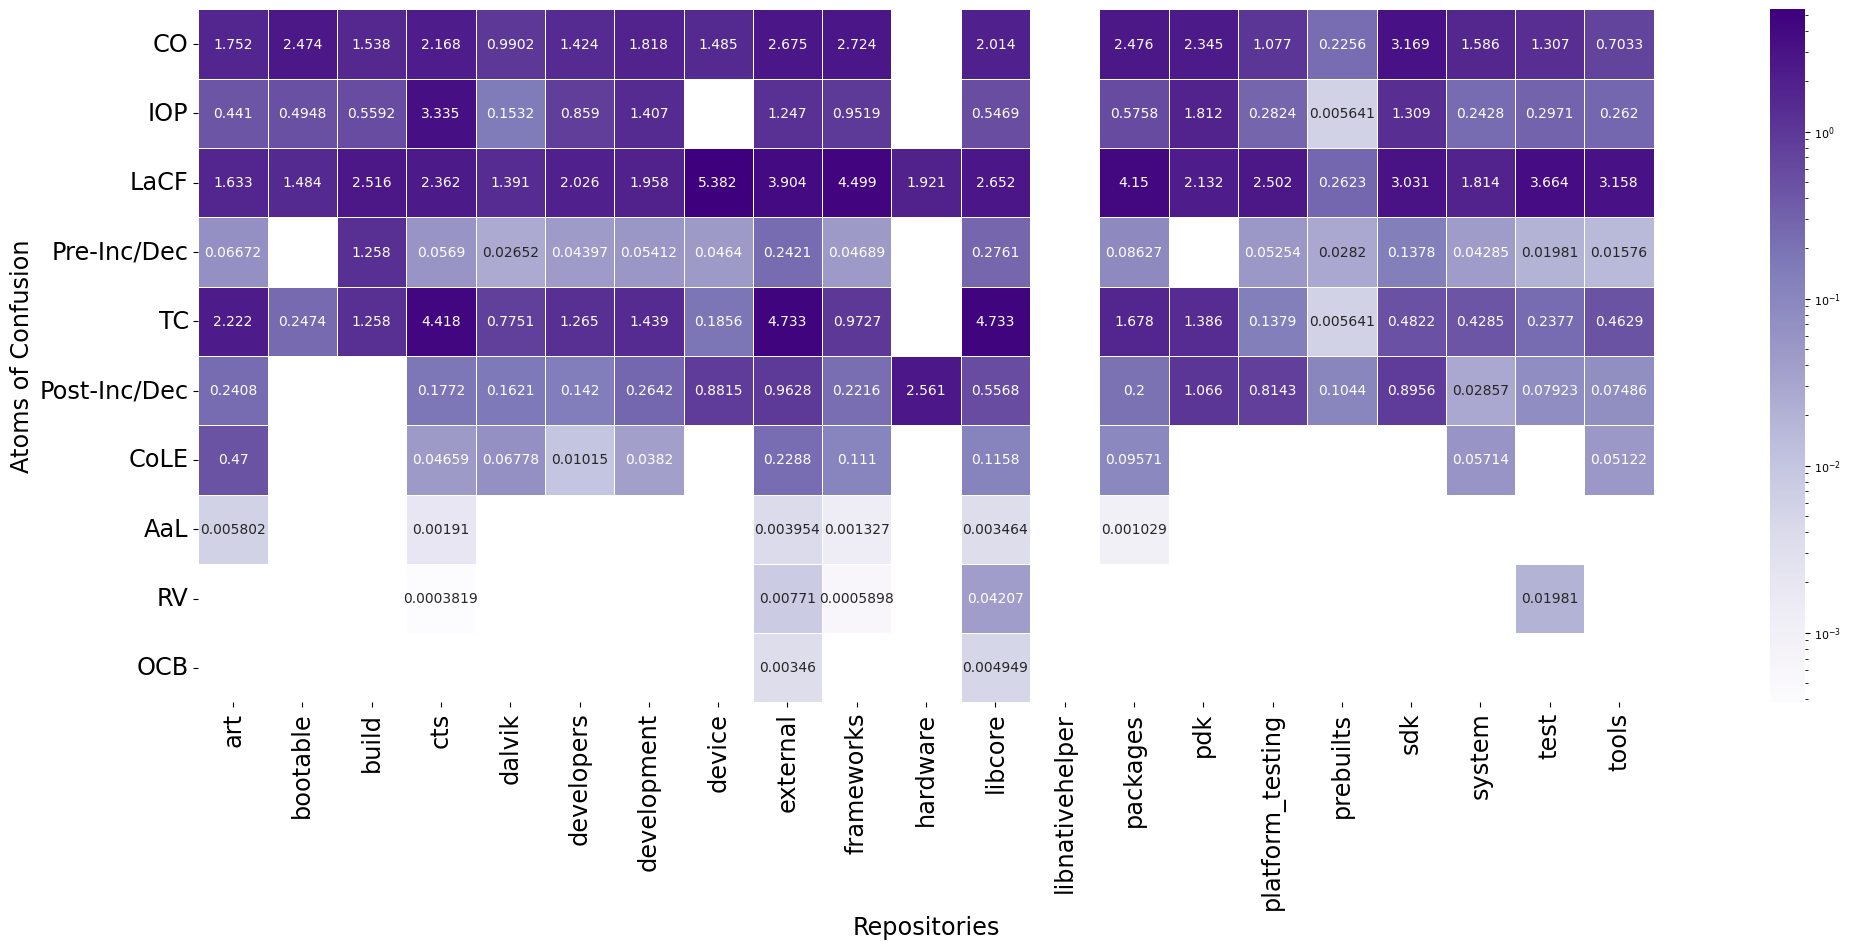

In [105]:
print_heatmap(heatmap_normalized.drop(columns=["loc"]), annot=True)

<Axes: xlabel='Repositories', ylabel='Atoms of Confusion'>

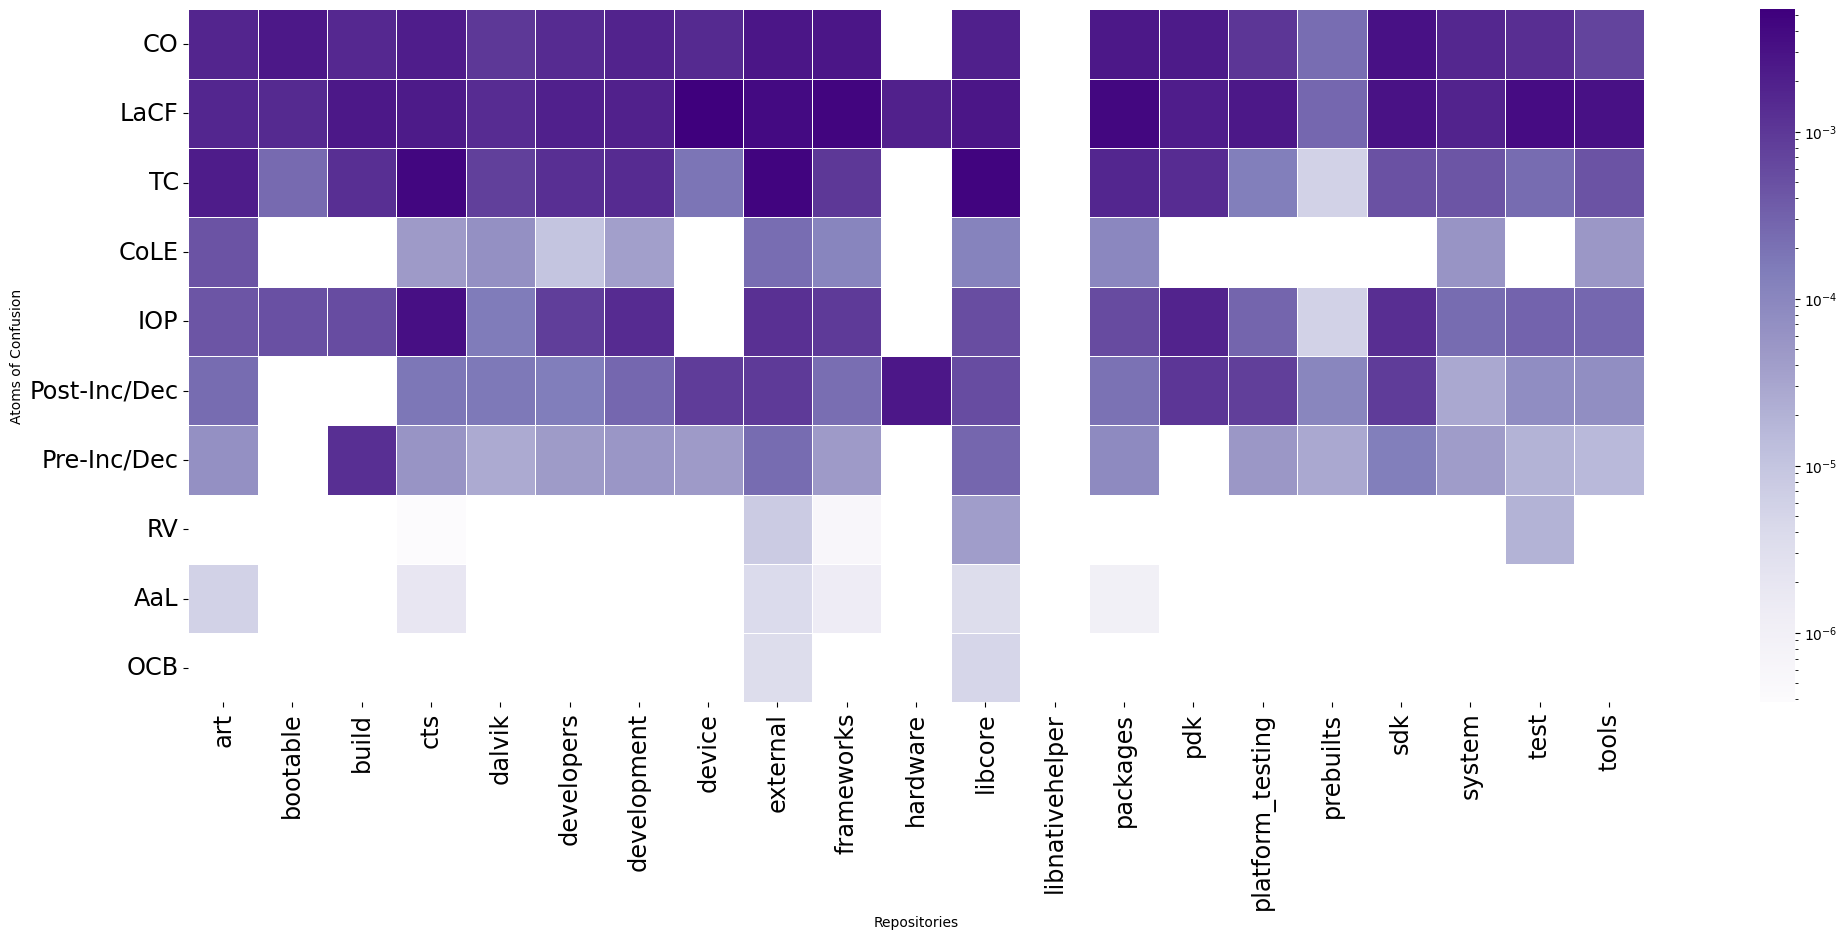

In [ ]:
print_heatmap(aggregate_heatmap_by_domain(heatmap, use_loc=True), title="AC per line of code for every root repository", annot=False)

## Scatterplot AC x LoC

In [ ]:
def get_ac_count_and_loc(project_name: str) -> dict:
    a = acs_in_a_project(project_name)
    a["loc"] = a["loc"].astype(int)
    group = a.groupby("path").aggregate({"ac_count": "sum", "loc": "max"})
    group = group.sum()
    return {
        "project_name": project_name,
        "ac_count": group["ac_count"],
        "loc": group["loc"]
    }

records = []
with ThreadPoolExecutor(max_workers=5) as executor:
    jobs = [executor.submit(get_ac_count_and_loc, project) for project in ALL_PROJECTS]
    for job in as_completed(jobs):
        records.append(job.result())
df_ac_x_loc = pd.DataFrame.from_records(records)


In [ ]:
domains = set([i.split("/")[0] for i in df_ac_x_loc["project_name"]])
df_ac_x_loc_aggregated = pd.DataFrame()
for domain in domains:
    temp = df_ac_x_loc.loc[df_ac_x_loc["project_name"].str.startswith(domain)]
    temp = temp.agg("sum")
    temp["project_name"] = domain
    temp = pd.DataFrame(temp.to_dict(), index=[0])
    df_ac_x_loc_aggregated = pd.concat([df_ac_x_loc_aggregated, temp], ignore_index=True)

In [ ]:
def get_domain(project_name: str) -> str:
    for domain in domains:
        if project_name.startswith(domain):
            return domain
    return project_name

In [ ]:
tab20 = colormaps.get_cmap("jet")
tab20_colors = tab20(np.linspace(0, 1, len(domains)))
domain_colors = {d: c for d,c in zip(domains, tab20_colors)}

In [ ]:
df_ac_x_loc_aggregated

,project_name,ac_count,loc
0,test,284,24156
1,build,51,4155
2,pdk,82,7140
3,art,2355,161627
4,dalvik,1210,89311
5,hardware,7,778
6,bootable,19,2936
7,development,2192,159546
8,tools,2400,243093
9,libnativehelper,0,0


## Investigate relationship between loc and ac

In [ ]:
def get_ac_x_loc_all_files():
    df_tmp = pd.DataFrame()
    for project in ALL_PROJECTS:
        _df = acs_files(project)
        df_tmp = pd.concat([df_tmp, _df])
    df_tmp = df_tmp.rename(columns={"count_acs": "ac_count"})
    return df_tmp

df_ac_x_loc_all_files = get_ac_x_loc_all_files()

In [ ]:
df_ac_x_loc_all_files.sort_values(by="ac_count", ascending=False).to_csv("df_ac_x_loc_all_files.csv")

In [ ]:
def investigate_relationship(_df: pd.DataFrame):
    # try linear
    import sklearn.metrics as skmetrics
    df = _df[_df["ac_count"] > 0]
    linear_model = LinearRegression()
    x_log_model = LinearRegression()
    y_log_model = LinearRegression()
    log_log_model = LinearRegression()
    x_data = df["loc"].to_numpy().reshape(-1, 1)
    y_data = df["ac_count"].to_numpy().reshape(-1, 1)
    linear_model.fit(x_data, y_data)
    x_log_model.fit(np.log(x_data), y_data)
    y_log_model.fit(x_data, np.log(y_data))
    log_log_model.fit(np.log(x_data), np.log(y_data))
    print("lin:", linear_model.score(x_data, y_data))
    print("linlog:", x_log_model.score(np.log(x_data), y_data))
    print("loglin:", y_log_model.score(x_data, np.log(y_data)))
    print("loglog:", log_log_model.score(np.log(x_data), np.log(y_data)))
investigate_relationship(df_ac_x_loc)

lin: 0.9088745863025232
linlog: 0.20806400893324384
loglin: 0.1669892593309259
loglog: 0.9278483579384875


In [ ]:
class LogLogRegressor:
    def __init__(self, **kwargs):
        self.model = LinearRegression(**kwargs)
    def fit(self, X, y):
        self.model.fit(np.log(X), np.log(y))
    def predict(self, X):
        return np.exp(self.model.predict(X))
    def score(self, X, y):
        return self.model.score(np.log(X), np.log(y))

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
RANDOM_STATE = 10
def model_eval(X, y, model, folds=5):
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X_train, y_train, cv=folds)
    blind_score = model.score(X_test, y_test)
    return (scores, blind_score)

def plot_ac_x_loc_with_log_regression(df: pd.DataFrame, quantile=1):
    _df_inner = df
    _df_inner = _df_inner[_df_inner["ac_count"] > 0]
    _df_inner = _df_inner[_df_inner["ac_count"] <= _df_inner["ac_count"].quantile(quantile)]
    # DRAW REGRESSION
    # Fit linear regression via least squares with numpy.polyfit
    # It returns an slope (b) and intercept (a)
    from sklearn.model_selection import GridSearchCV
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import PolynomialFeatures

    model = LinearRegression()
    x_data = _df_inner["loc"].to_numpy().reshape(-1, 1)
    y_data = _df_inner["ac_count"].to_numpy().reshape(-1, 1)
    model.fit(np.log(x_data), np.log(y_data))
    regseq = np.linspace(_df_inner["loc"].min(), _df_inner["loc"].max(), _df_inner.shape[0])

    top_projects = _df_inner.sort_values("ac_count", ascending=False).head(20)["project_name"].to_list()
    scatter_colors = []
    for idx, row in _df_inner.iterrows():
        scatter_colors.append(domain_colors.get(get_domain(row["project_name"]), "black"))
        if row["project_name"] in top_projects:
            continue
            ax.annotate(row['project_name'], (row['loc'], row['ac_count']))

    # plt.title("Size of projects vs number of ACs")

    plt.rcParams.update({"font.size": 10, "axes.titlesize": 15})
    plt.rc("axes", labelsize=12)
    plt.rc("xtick", labelsize=12)
    plt.rc("ytick", labelsize=12)
    ax = _df_inner.plot(kind="scatter", x="loc", y="ac_count")
    score = model.score(np.log(x_data), np.log(y_data))
    lbl = "y=%0.4fx + %0.4f \n$R^2=%0.4f$"%(model.coef_[0][0], model.intercept_[0],score)
    ax.plot(regseq, np.exp(model.predict(np.log(regseq.reshape(-1,1)))), color="k", label=lbl)
    handles = [mpatches.Patch(color=color, label=domain )for domain,color in domain_colors.items()]

    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.figure.set_size_inches((12,9))
    # ax.legend(handles=handles)
    ax.legend()
def plot_ac_x_loc_with_lin_regression(df: pd.DataFrame, quantile=1):
    _df_inner = df
    _df_inner = _df_inner[_df_inner["ac_count"] > 0]
    _df_inner = _df_inner[_df_inner["ac_count"] <= _df_inner["ac_count"].quantile(quantile)]
    # DRAW REGRESSION
    # Fit linear regression via least squares with numpy.polyfit
    # It returns an slope (b) and intercept (a)
    from sklearn.model_selection import GridSearchCV
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import PolynomialFeatures

    model = LinearRegression()
    x_data = _df_inner["loc"].to_numpy().reshape(-1, 1)
    y_data = _df_inner["ac_count"].to_numpy().reshape(-1, 1)
    model.fit(x_data, y_data)
    regseq = np.linspace(_df_inner["loc"].min(), _df_inner["loc"].max(), _df_inner.shape[0])

    top_projects = _df_inner.sort_values("ac_count", ascending=False).head(20)["project_name"].to_list()
    scatter_colors = []
    for idx, row in _df_inner.iterrows():
        scatter_colors.append(domain_colors.get(get_domain(row["project_name"]), "black"))
        if row["project_name"] in top_projects:
            continue
            ax.annotate(row['project_name'], (row['loc'], row['ac_count']))

    # plt.title("Size of projects vs number of ACs")

    plt.rcParams.update({"font.size": 10, "axes.titlesize": 15})
    plt.rc("axes", labelsize=12)
    plt.rc("xtick", labelsize=12)
    plt.rc("ytick", labelsize=12)
    ax = _df_inner.plot(kind="scatter", x="loc", y="ac_count")
    score = model.score(x_data, y_data)
    lbl = "y=%0.4fx + %0.4f \n$R^2=%0.4f$"%(model.coef_[0][0], model.intercept_[0],score)
    ax.plot(regseq, model.predict(regseq.reshape(-1,1)), color="k", label=lbl)
    handles = [mpatches.Patch(color=color, label=domain )for domain,color in domain_colors.items()]

    ax.figure.set_size_inches((12,9))
    # ax.legend(handles=handles)
    ax.legend()
plot_ac_x_loc_with_log_regression(df_ac_x_loc, quantile=.99)

NameError: name 'df_ac_x_loc' is not defined

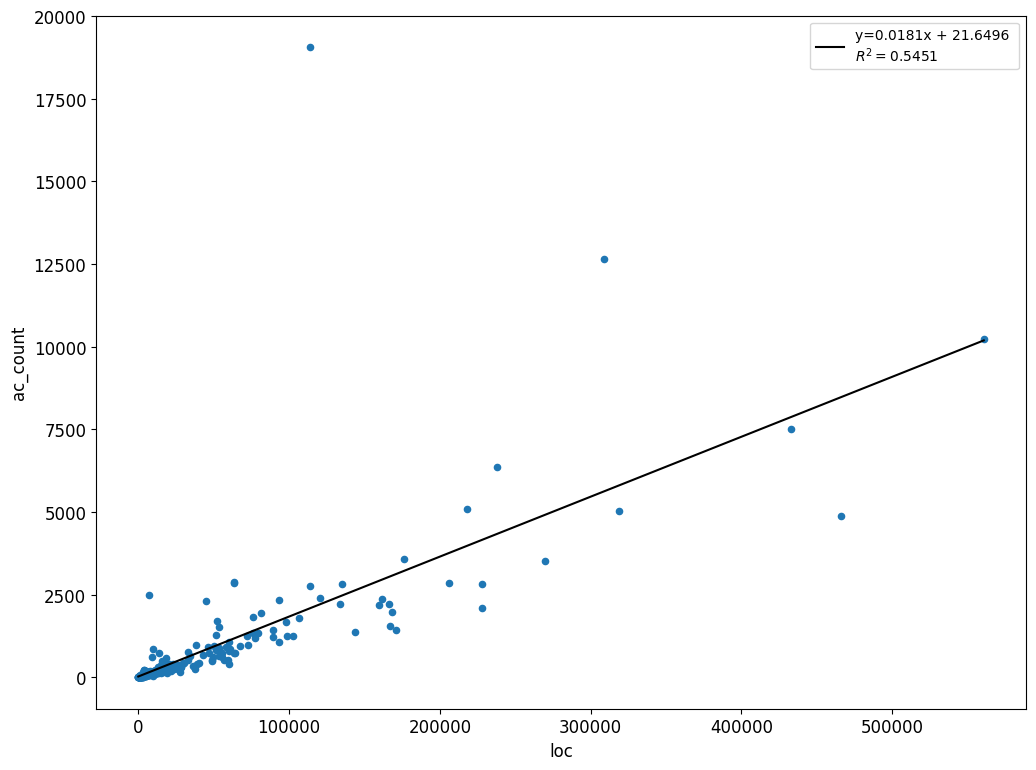

In [ ]:
plot_ac_x_loc_with_lin_regression(df_ac_x_loc, quantile=.99)

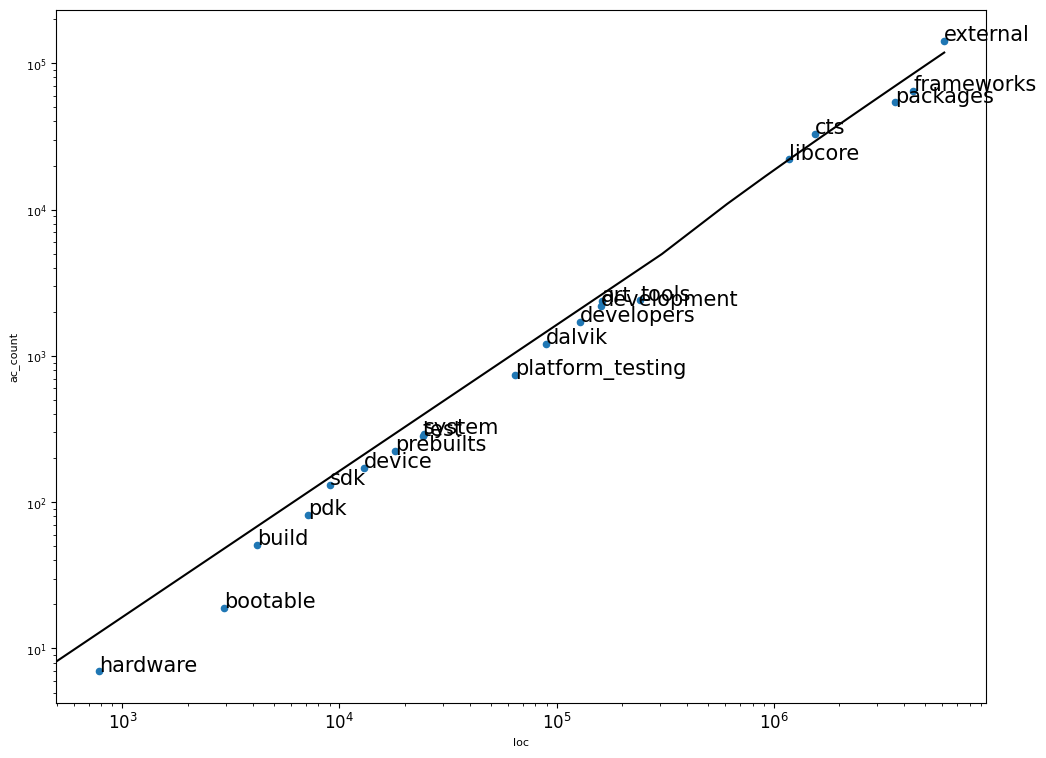

In [ ]:
ax = df_ac_x_loc_aggregated.plot(kind="scatter", x="loc", y="ac_count")
ax.set_yscale("log")
ax.set_xscale("log")
plt.rcParams.update({"font.size": 15, "axes.titlesize": 15})
plt.rc("axes", labelsize=8)
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=8)
# DRAW REGRESSION
# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
b, a = np.polyfit(df_ac_x_loc_aggregated["loc"], df_ac_x_loc_aggregated["ac_count"], deg=1)
regseq = np.linspace(0, df_ac_x_loc_aggregated["loc"].max(), df_ac_x_loc_aggregated.shape[0])
ax.plot(regseq, a + b * regseq, color="k")
top_projects = df_ac_x_loc_aggregated.sort_values("ac_count", ascending=False).head(20)["project_name"].to_list()
for idx, row in df_ac_x_loc_aggregated.iterrows():
    if row["project_name"] in top_projects:
        ax.annotate(row['project_name'], (row['loc'], row['ac_count']))
ax.figure.set_size_inches((12,9))
# plt.title("Size of projects vs number of ACs")

# Violin plot

In [ ]:
files_with_acs = []
files_without_acs = []
for project_name in ALL_PROJECTS:
    files_with_acs.extend(report_files_with_acs(project_name).to_list())
    files_without_acs.extend(report_files_without_acs(project_name).to_list())
files_with_acs = pd.Series(files_with_acs)
files_without_acs = pd.Series(files_without_acs)

In [ ]:
files_with_acs[0]

'/AOSP/packages/providers/UserDictionaryProvider/src/com/android/providers/userdictionary/DictionaryBackupAgent.java'

In [ ]:
try:
    df_ck_in_file = pd.read_csv("ck_files_with_acs.csv")
except:
    df_ck_in_file = pd.DataFrame()
if df_ck_in_file.empty:
    df_ck_in_file = []
    cols = []
    for file in files_with_acs:
        result = ck_in_file(file)
        df_ck_in_file.extend(result.to_records(index=False))
        if not cols:
            cols = result.columns.to_list()
    df_ck_in_file = pd.DataFrame.from_records(df_ck_in_file, columns=cols)
    df_ck_in_file = df_ck_in_file.groupby("file_path").agg(agg_methods, numeric_only=True).reset_index()
    df_ck_in_file.to_csv("ck_files_with_acs.csv", index=False)


In [ ]:
try:
    df_ck_ac_not_in_file = pd.read_csv("ck_files_without_acs.csv")
except:
    df_ck_ac_not_in_file = pd.DataFrame()
if df_ck_ac_not_in_file.empty:
    df_ck_ac_not_in_file = []
    cols = []
    for file in files_without_acs:
        result = ck_in_file(file)
        df_ck_ac_not_in_file.extend(result.to_records(index=False))
        if not cols:
            cols = result.columns.to_list()
    df_ck_ac_not_in_file = pd.DataFrame.from_records(df_ck_ac_not_in_file, columns=cols)
    df_ck_ac_not_in_file = df_ck_ac_not_in_file.groupby("file_path").agg(agg_methods, numeric_only=True).reset_index()
    df_ck_ac_not_in_file.to_csv("ck_files_without_acs.csv", index=False)

Text(0.5, 0.98, 'AOSP metrics comparison')

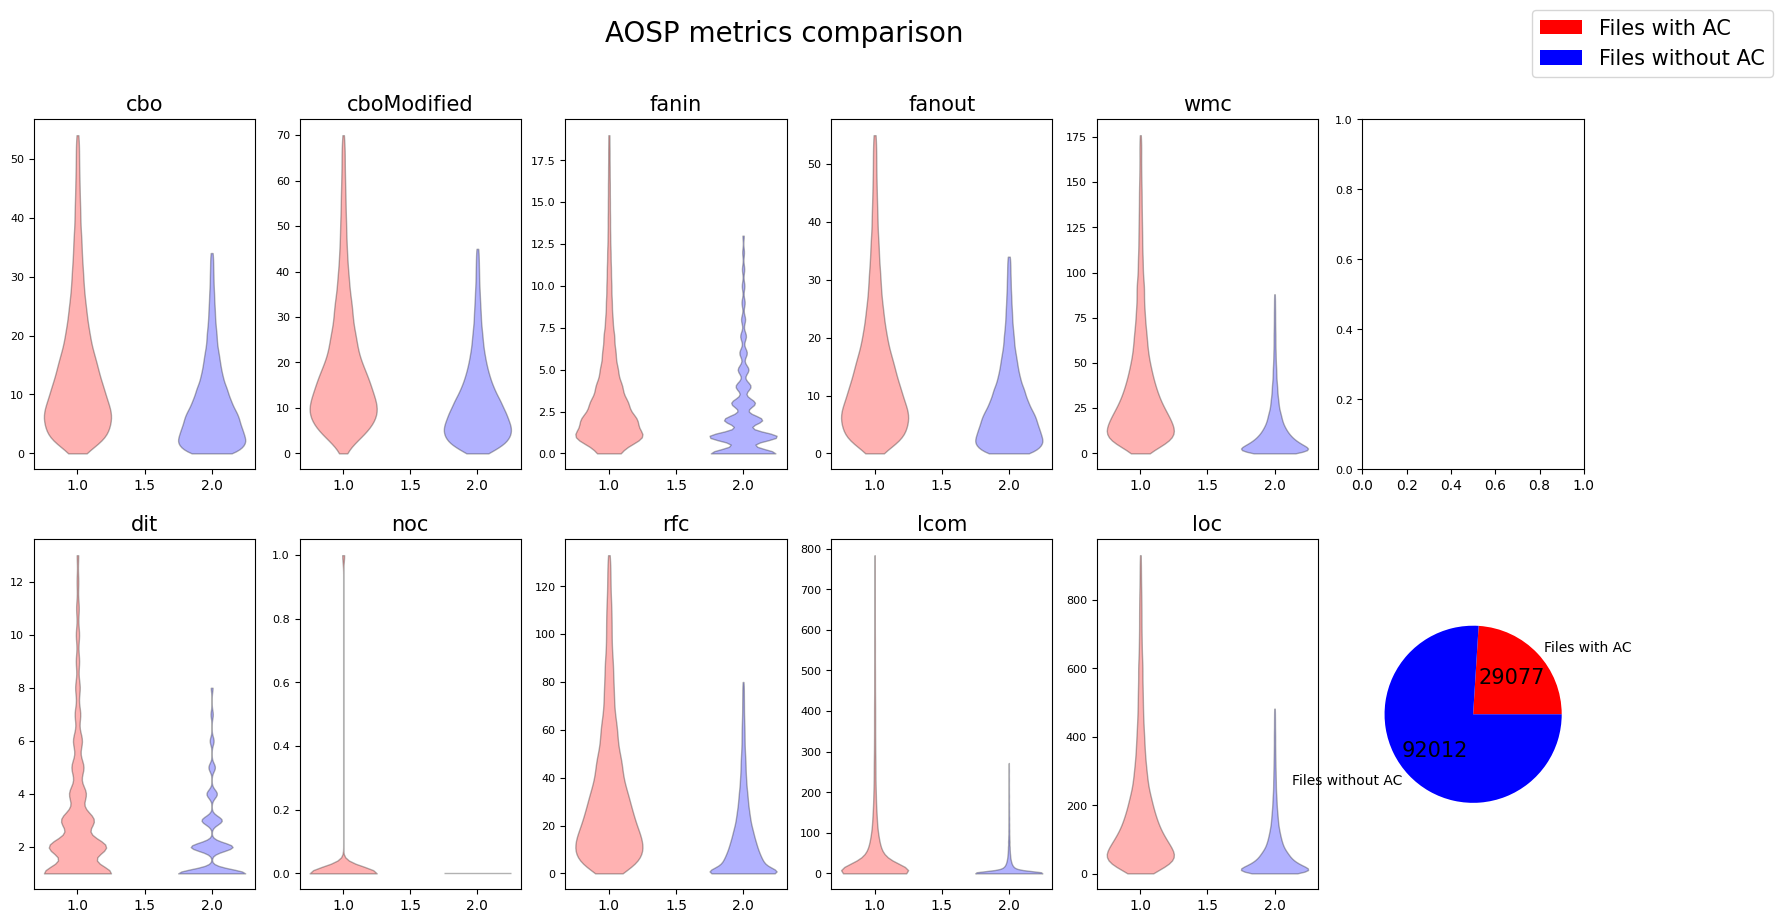

In [ ]:
# plot violins
VIOLIN_COLORS = ["red", "blue"]
columns_to_check = ["cbo", "cboModified", "fanin", "fanout", "wmc","dit", "noc", "rfc", "lcom", "loc"]
fig, axs = plt.subplots(nrows=len(columns_to_check)//5, ncols=5+1, figsize=(20,10))

n_files_with_ac = df_ck_in_file["file_path"].size
n_files_without_ac = df_ck_ac_not_in_file["file_path"].size
set_sizes = [n_files_with_ac, n_files_without_ac]
_,_, autotexts = axs[-1, -1].pie(set_sizes, labels=["Files with AC", "Files without AC"], autopct='', colors=VIOLIN_COLORS)
for i, txt in enumerate(autotexts):
    txt.set_text(f"{set_sizes[i]}")

for i, column in enumerate(columns_to_check):
    if column == "file_path":
        continue
    eye = i // 5
    j = i % 5
    quantile_with_ac = df_ck_in_file[column].quantile(.95)
    quantile_without_ac = df_ck_ac_not_in_file[column].quantile(.95)
    filtered_with_ac = df_ck_in_file[df_ck_in_file[column] < quantile_with_ac][column]
    filtered_without_ac = df_ck_ac_not_in_file[df_ck_ac_not_in_file[column] < quantile_without_ac][column]
    try:
        violins = axs[eye,j].violinplot([filtered_with_ac, filtered_without_ac], showextrema=False)
    except:
        continue
    axs[eye,j].set_title(column)
    for c, body in enumerate(violins["bodies"]):
        body.set_facecolor(VIOLIN_COLORS[c])
        body.set_edgecolor("black")
fig.legend()
plt.suptitle("AOSP metrics comparison", fontsize=20)


/tmp/ipykernel_7690/909145008.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()


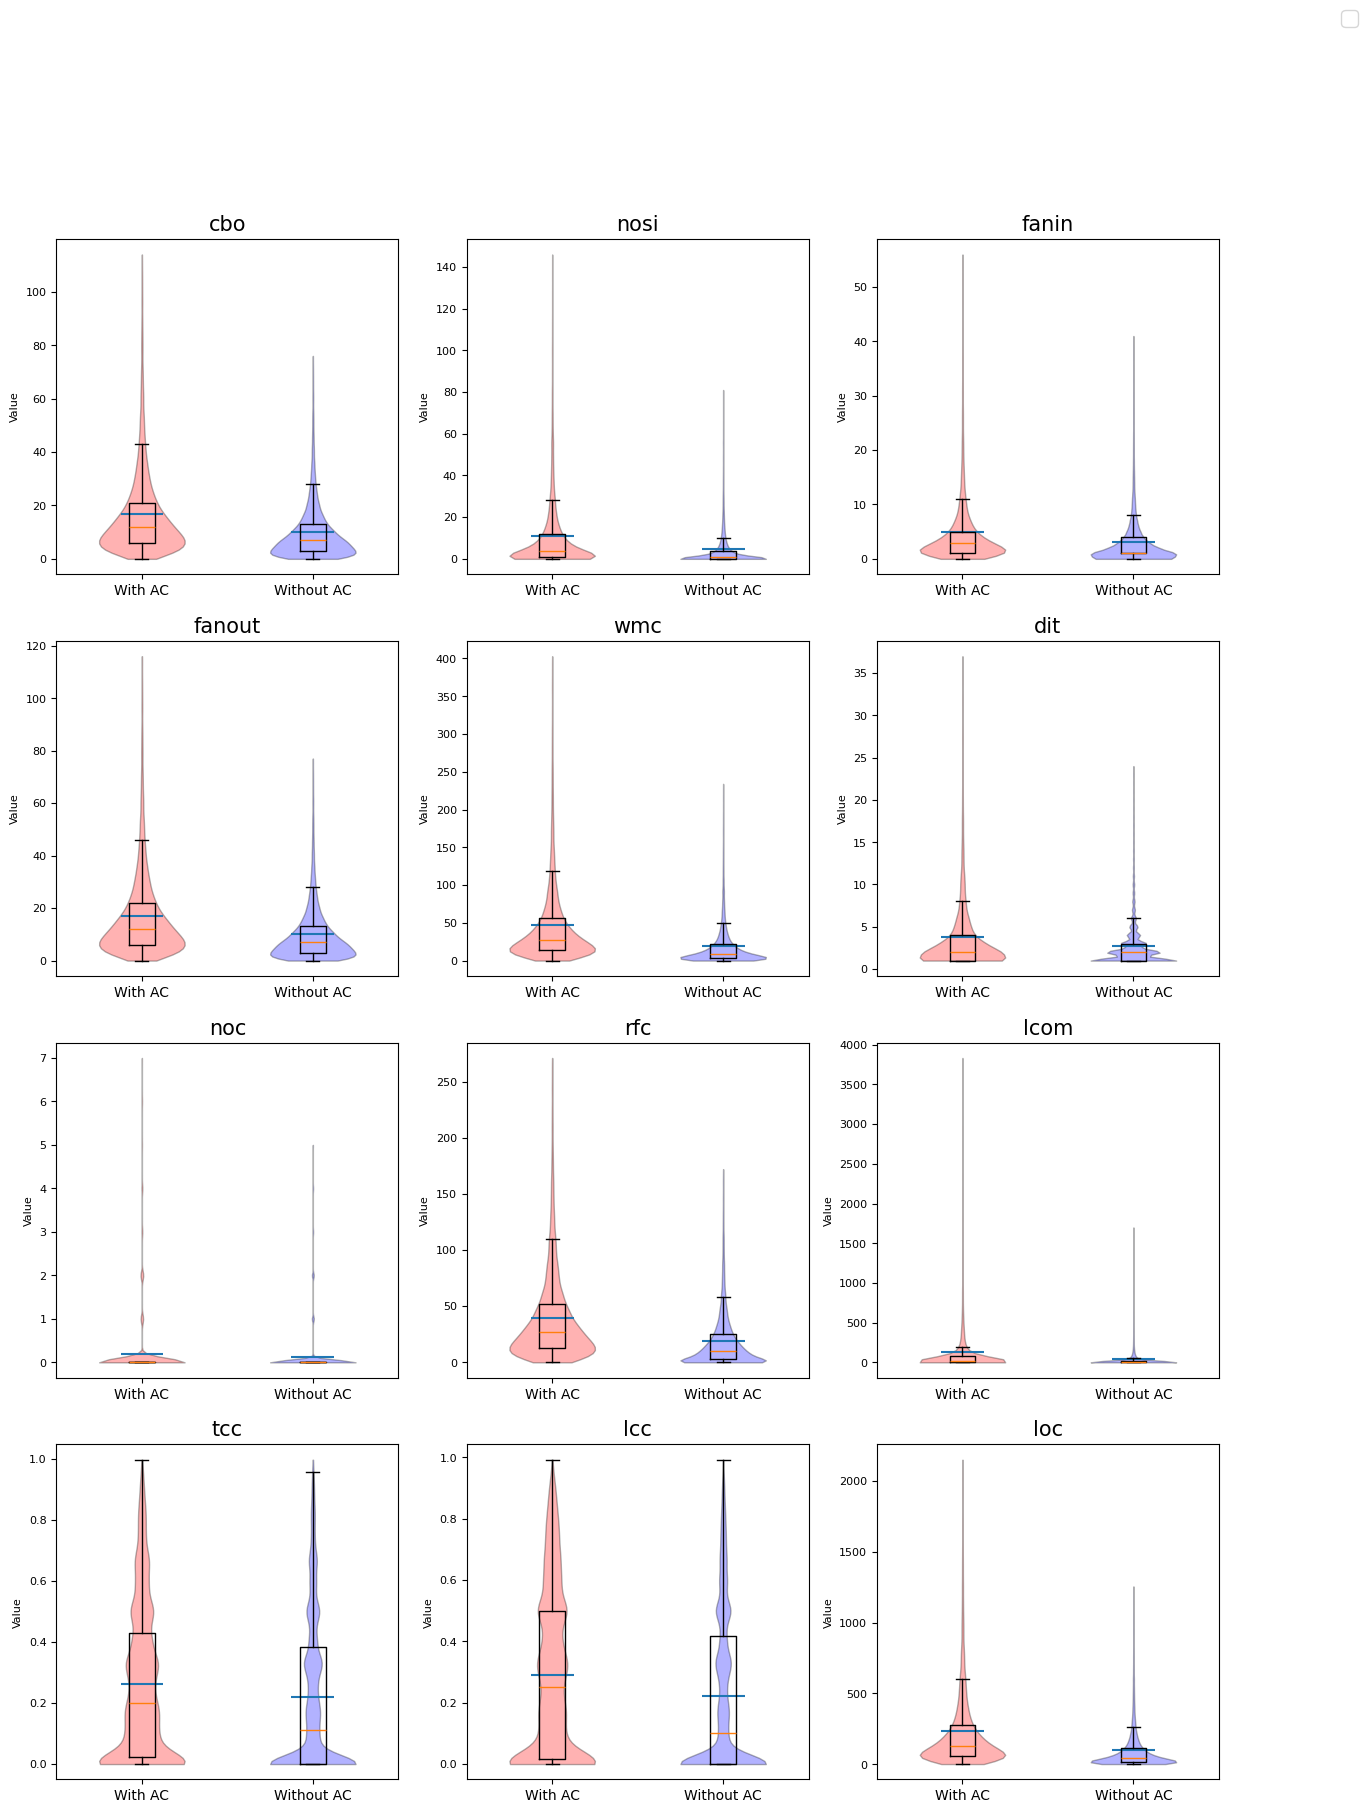

In [ ]:
# plot violins without pie chart
VIOLIN_COLORS = ["red", "blue"]
columns_to_check = ["cbo", "nosi", "fanin", "fanout", "wmc","dit", "noc", "rfc", "lcom", "tcc", "lcc", "loc"]
COLUMNS = 3
plt.rcParams.update({"font.size": 15, "axes.titlesize": 15})
plt.rc("axes", labelsize=8)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=8)
fig, axs = plt.subplots(nrows=len(columns_to_check)//COLUMNS, ncols=COLUMNS, figsize=(15,20))
n_files_with_ac = df_ck_in_file["file_path"].size
n_files_without_ac = df_ck_ac_not_in_file["file_path"].size
set_sizes = [n_files_with_ac, n_files_without_ac]

# _,_, autotexts = axs[-1, -1].pie(set_sizes, labels=["Files with AC", "Files without AC"], autopct='', colors=VIOLIN_COLORS)

for i, txt in enumerate(autotexts):
    txt.set_text(f"{set_sizes[i]}")

for i, column in enumerate(columns_to_check):
    if column == "file_path":
        continue
    eye = i // COLUMNS
    j = i % COLUMNS
    quantile_with_ac = df_ck_in_file[column].quantile(.99)
    quantile_without_ac = df_ck_ac_not_in_file[column].quantile(.99)
    filtered_with_ac = df_ck_in_file[df_ck_in_file[column] < quantile_with_ac][column]
    filtered_without_ac = df_ck_ac_not_in_file[df_ck_ac_not_in_file[column] < quantile_without_ac][column]
    if column in ["tcc", "lcc"]: # remove invalid -1 values
        filtered_with_ac = filtered_with_ac[filtered_with_ac >= 0]
        filtered_without_ac = filtered_without_ac[filtered_without_ac >= 0]
    try:
        violins = axs[eye,j].violinplot([filtered_with_ac, filtered_without_ac], showextrema=False, showmeans=True)
        axs[eye,j].boxplot([filtered_with_ac, filtered_without_ac], showfliers=False)
    except:
        continue
    axs[eye, j].set_title(column)
    axs[eye, j].set_xticks([1,2], ["With AC", 'Without AC'])
    axs[eye, j].set_ylabel("Value")
    # axs[eye, j].set_xticks()
    # axs[eye, j].legend(handles=axs[eye, j].legend_.legendHandles, labels=['Survived', 'Not survived'])

    for c, body in enumerate(violins["bodies"]):
        body.set_facecolor(VIOLIN_COLORS[c])
        body.set_edgecolor("black")
fig.set_label("Files with AC")
fig.legend()



# plt.suptitle("AOSP metrics comparison", fontsize=20)

In [ ]:
df_ck_in_file

,file_path,cbo,cboModified,fanin,fanout,wmc,dit,noc,rfc,lcom,...,assignmentsQty,mathOperationsQty,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty
0,/AOSP/art/benchmark/type-check/src/TypeCheckBe...,17,31,14,17,33,43,6,2,55,...,44,0,39,2,0,0,0,47,1,0
1,/AOSP/art/libartservice/service/java/com/andro...,96,107,11,96,128,10,0,172,44,...,84,3,80,6,0,5,14,798,38,0
2,/AOSP/art/libartservice/service/java/com/andro...,34,36,2,34,136,3,0,110,140,...,94,25,75,4,0,1,2,471,27,0
3,/AOSP/art/libartservice/service/java/com/andro...,41,46,5,41,36,9,0,59,41,...,29,1,26,3,0,4,5,152,2082,0
4,/AOSP/art/libartservice/service/java/com/andro...,2,10,8,2,8,1,0,3,15,...,1,0,1,0,0,0,0,30,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29072,/AOSP/tools/tradefederation/core/test_result_i...,5,46,41,5,46,1,1,16,208,...,29,8,14,2,0,0,0,105,1,0
29073,/AOSP/tools/tradefederation/core/test_result_i...,3,78,75,3,28,1,0,21,73,...,14,4,10,2,0,0,0,115,17,0
29074,/AOSP/tools/tradefederation/core/util_apps/Con...,9,10,1,9,48,3,0,43,59,...,46,3,32,4,1,0,0,165,0,0
29075,/AOSP/tools/tradefederation/core/util_apps/Tel...,16,17,1,16,16,6,0,22,0,...,20,0,18,5,1,2,0,100,4,0
